In [20]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import numpy as np
import seaborn as sns
import sys
import viz
sys.path.append('../notebooks_llm/')
plt.style.use('default')
dvu.set_style()
UNKS = {"Unk", "-", -1, "-1"}
df = pd.read_pickle('../data/data_clean.pkl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Overall study counts

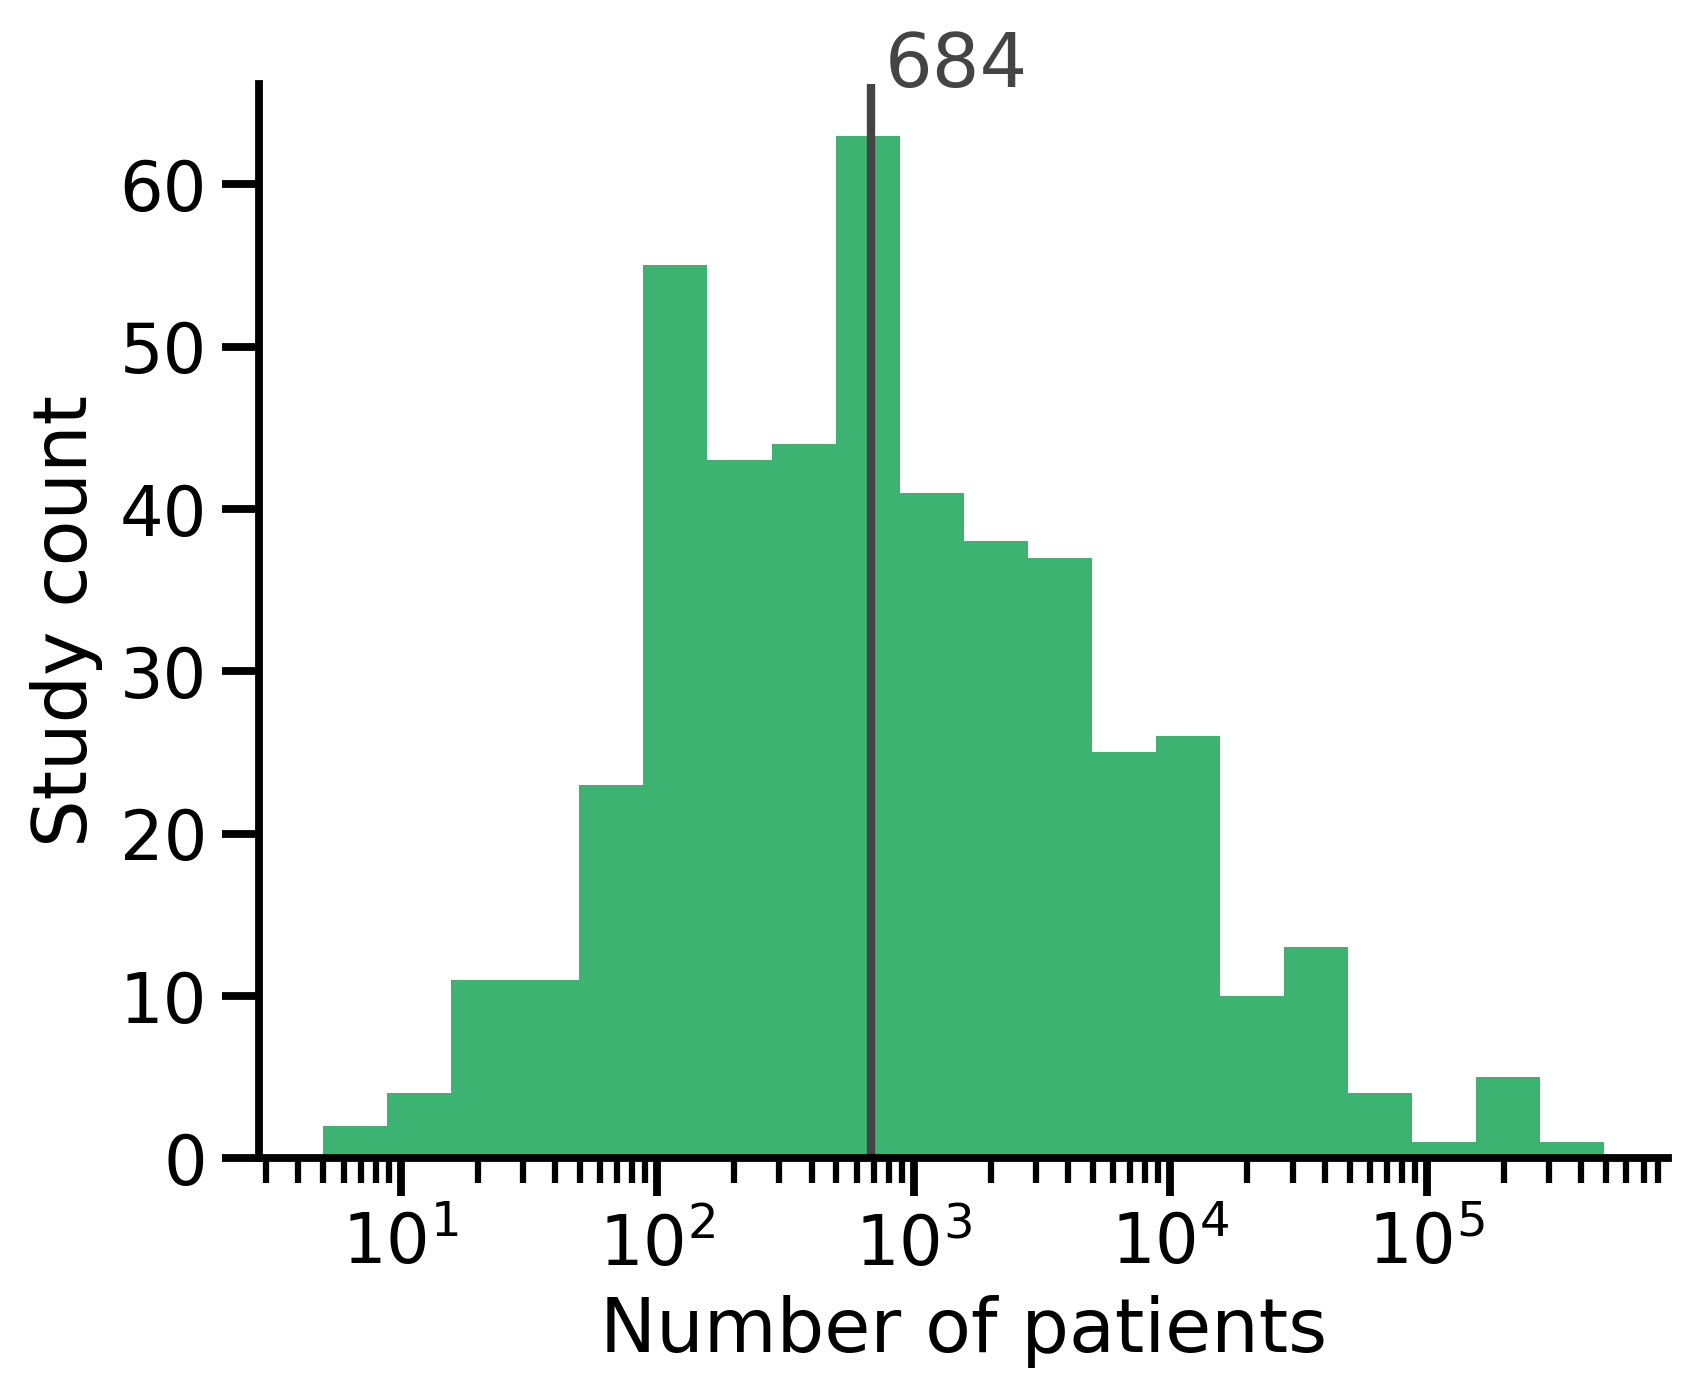

In [18]:
x = df['participants___total']
x = x[x > 0]
hist, bins, _ = plt.hist(x, bins=20)
plt.cla()
plt.close()
# histogram on log scale.
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
sns.set_context('talk')
plt.figure(dpi=300, figsize=(6, 5))
avg = np.median(x)
plt.axvline(x=avg, ls='-', color='#444', lw=2)
plt.text(s=f'{avg:,.0f}', x=avg + 90, y=66, color='#444')
plt.hist(x, bins=logbins, color='mediumseagreen')
plt.xscale("log")
plt.xlabel('Number of patients')
plt.ylabel('Study count')
# plt.title('C', loc='left', fontsize='x-large', fontweight='bold')
viz.savefig('num_patients_hist')
plt.show()

### Race ratios

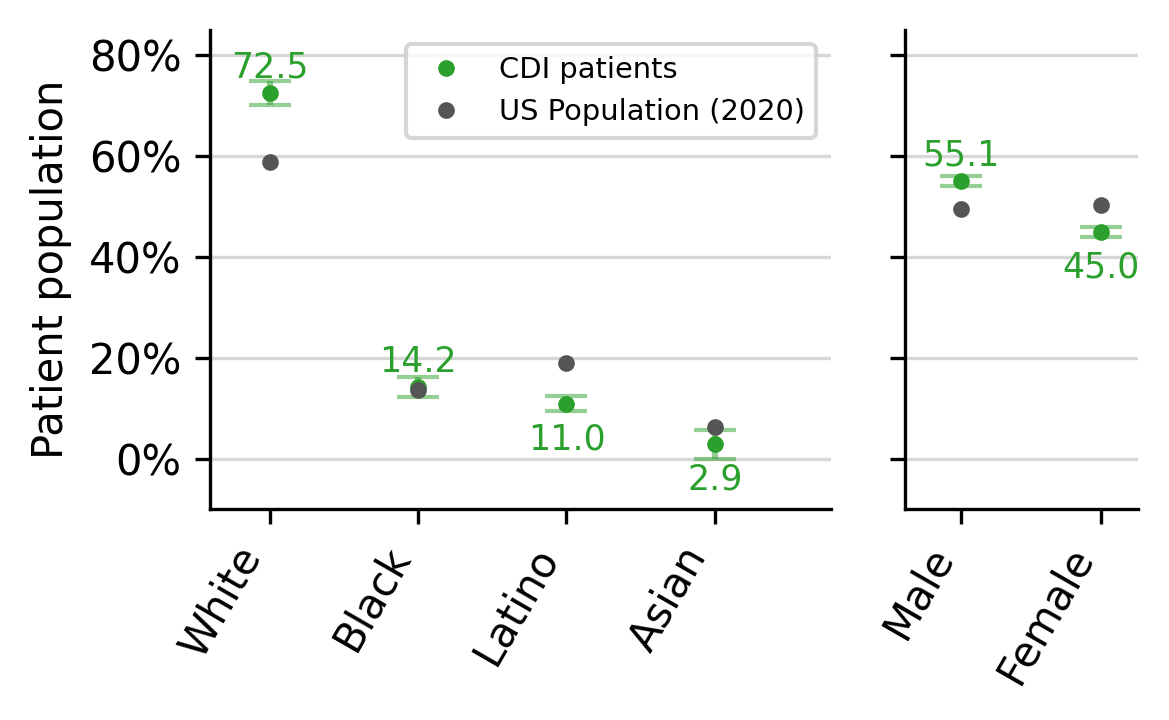

In [25]:
def get_race_vals(race_keys=[
    "participants___white",
    "participants___black",
    "participants___latino",
    "participants___asian",
]):

    race_vals_dict = defaultdict(list)
    for k in race_keys:
        idxs = df[k].notnull() & ~(df[k].isin(UNKS))
        d = df[idxs]
        vals = df[k][idxs]
        vals_perc = []
        for i, v in vals.items():
            # if eval_extraction.str_is_percentage(v):
            # vals_perc.append(eval_extraction.percentage_to_num(v))
            # else:

            vals_perc.append(100 * float(v) / d["participants___total"][i])
            assert (
                vals_perc[-1] <= 100 and vals_perc[-1] >= 0
            ), f"key={k} original_val={v} val_percentage={vals_perc[-1]} {d['participants___total'][i]}"
        # vals = [float(v[:-1]) for v in vals]
        # print(vals.values, vals_perc)
        race_vals_dict[k] = vals_perc
    return race_vals_dict


def make_plot(vals_dict, BASELINE_DICT, ax, hide_yaxis=False):
    for i, (k, v) in enumerate(vals_dict.items()):
        kwargs = {}
        if i == len(vals_dict) - 1:
            kwargs["label"] = "CDI patients"

        # plt.plot(np.random.normal(i, 0.05, len(v)), v, 'o', alpha=0.5, color='C0', ms=2, **kwargs)
        median = np.median(v)
        ax.plot(i, median, "o", color="C2", ms=3, **kwargs)  # , ms=3)
        ax.errorbar(
            i,
            median,
            yerr=np.std(v) / np.sqrt(len(v)),
            color="C2",
            capsize=5,
            alpha=0.5,
        )  # , ms=3)

        if i == len(vals_dict) - 1:
            kwargs["label"] = "US Population (2020)"
        # plot census
        val = BASELINE_DICT[list(BASELINE_DICT.keys())[i]]
        ax.plot(i, val, "o", color="#555", ms=3, **kwargs)  # , ms=3)

        # annotate value above each point
        v = median
        diff = -9 + (v > val) * 12
        ax.annotate(
            f"{v.round(1)}",
            (i, v),
            xytext=(i, v + diff),
            ha="center",
            color="C2",
            fontsize="small",
        )

    ax.set_xticks(
        labels=list(BASELINE_DICT.keys()),
        ticks=range(len(BASELINE_DICT)),
        rotation=60,
        ha="right",
    )
    ax.set_yticks(ticks=range(0, 100, 20), labels=[
        f"{t}%" for t in range(0, 100, 20)])
    ax.set_ylabel("Patient population")
    if hide_yaxis:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.set_xlim(left=-0.4, right=ax.get_xlim()[1] * 1.2)
    ax.set_ylim(bottom=-10, top=85)
    ax.grid(axis="y", alpha=0.5)


race_vals_dict = get_race_vals()
gender_vals_dict = get_race_vals(
    ['participants___male', 'participants___female'])
GENDER_BASELINES = {
    'Male': 49.6,
    'Female': 50.4,
}

RACE_BASELINES = {
    "White": 58.9,
    "Black": 13.6,
    "Latino": 19.1,
    "Asian": 6.3,
}

# make boxplot
# sns.set_context('notebook')
# fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
f, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [
                       0.8, 0.3]}, dpi=300, figsize=(4, 2.5))

# ax = axes[0]
make_plot(race_vals_dict, RACE_BASELINES, axes[0])
axes[0].legend(fontsize='x-small')
# axes[0].set_title('A', x=0, y=1, fontweight='bold')
make_plot(gender_vals_dict, GENDER_BASELINES, axes[1], hide_yaxis=True)
# axes[1].set_title('B', x=0, y=1, fontweight='bold')

# plot gender vals
plt.tight_layout()
viz.savefig('patient_population')
plt.show()

In [26]:
# run t-tests for race baselines and gender
from scipy.stats import ttest_1samp, false_discovery_control
i = 0
ps = []
for k, v in race_vals_dict.items():
    baseline = list(RACE_BASELINES.values())[i]
    i += 1
    t, p = ttest_1samp(v, baseline)
    print(k, t, p)
    ps.append(p)
    print('\tmeans', np.mean(v), baseline)
    print('\tmedians', np.median(v), baseline)
print('FDR', false_discovery_control(ps))

participants___white 2.681979893718261 0.00867583230352623
	means 65.15315570802797 58.9
	medians 72.49631811487481 58.9
participants___black 3.3181791857569727 0.0013854382649470685
	means 20.31444700430686 13.6
	medians 14.244835813022263 13.6
participants___latino -3.5956515290839257 0.000710218410940492
	means 13.690476515233554 19.1
	medians 10.975278456941048 19.1
participants___asian 0.7782428971846989 0.441511074257104
	means 8.563325407216917 6.3
	medians 2.9411764705882355 6.3
FDR [0.01156778 0.00277088 0.00277088 0.44151107]


In [27]:
# run t-tests for race baselines and gender
i = 0
ps = []
for k, v in gender_vals_dict.items():
    baseline = list(GENDER_BASELINES.values())[i]
    i += 1
    t, p = ttest_1samp(v, baseline)
    print(k, t, p)
    ps.append(p)
    print('\tmeans', np.mean(v), baseline)
    print('\tmedians', np.median(v), baseline)
print('FDR', false_discovery_control(ps))

participants___male 5.246340006942988 2.607494141805138e-07
	means 54.75911987286683 49.6
	medians 55.115487675720104 49.6
participants___female -4.431969195517503 1.225065618876037e-05
	means 45.86989655948385 50.4
	medians 45.038167938931295 50.4
FDR [5.21498828e-07 1.22506562e-05]


# Author affilliation plots

In [ ]:
def to_num(x):
    return float(x.replace("%", ""))


def make_plot(tab, ax):
    # plot with no connecting line
    ax.plot(
        tab["CDI Author affiliations"].apply(to_num),
        label="CDI authors",
        color="C0",
        marker="o",
        ms=3,
        linestyle="None",
    )

    # annotate value above each point
    for i, v in enumerate(tab["CDI Author affiliations"].apply(to_num)):
        ax.annotate(
            f"{v}",
            (i, v),
            xytext=(i, v + 3),
            ha="center",
            color="C0",
            fontsize="small",
        )

    def calc_bernoulli_sem(fracs, n):
        return np.sqrt(fracs * (1 - fracs) / n)

    sems = calc_bernoulli_sem(
        tab["CDI Author affiliations"].apply(to_num) / 100, n=1234)
    ax.errorbar(
        range(len(tab)),
        tab["CDI Author affiliations"].apply(to_num),
        yerr=sems * 100,
        color="C0",
        # color='darkgreen',
        capsize=5,
        alpha=0.5,
        linestyle="None",
    )

    ax.plot(
        tab["World population (UN Geoscheme, 2021)"].apply(to_num),
        label="World population (2022)",
        color="#555",
        marker="o",
        ms=3,
        linestyle="None",
    )

    ax.grid(axis="y", alpha=0.5)
    ax.set_xticks(labels=tab.index.values, ticks=range(
        len(tab)), rotation=60, ha="right")


# fig = plt.figure(figsize=(9, 3), dpi=300)
f, axes = plt.subplots(1, 3, gridspec_kw={'width_ratios': [
                       1, 3, 0.4]}, dpi=300, figsize=(8, 3))
tits = ['Continent', 'Country', '\nSex\n(Inferred)']
for i, k in enumerate(['continents', 'countries', 'gender']):
    ax = axes[i]
    # plt.subplot(1, 3, i + 1, width_ratios=[1, 2, 1])
    tab = pd.read_csv(f'../data/author_affil_{k}.csv', header=0)
    tab = tab.rename(columns={'Unnamed: 0': 'Source'})
    tab = tab.set_index('Source')
    # tab = tab.set_index('Unnamed: 0') # = tab['Unnamed: 0']
    tab = tab.T
    make_plot(tab, ax)

    yticks = range(0, 75, 10)
    ax.set_yticks(ticks=yticks, labels=[f"{t}%" for t in yticks])
    ax.set_ylim(bottom=0, top=75)
    if i == 0:
        ax.set_ylabel("Author population")
    else:
        # hide y axis
        # ax.set_yticks([])
        ax.set_yticklabels([])

    # ax.set_title('ABC'[i], x=0, y=1.05, fontweight='bold')

    if i == 1:
        # plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1)

        # set legend background to white with no transparency
        ax.legend(facecolor='w', framealpha=1)

    if i == 0:
        ax.set_xlim(left=-0.6)
    if i == 2:
        ax.set_xlim(left=-0.4, right=ax.get_xlim()[1] * 1.2)
    ax.set_xlabel(tits[i])

    # put legend above plot
    # if i == 1:
    # plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
# make shared legend above all subplots
# fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
# plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

# make legend to the right of plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
viz.savefig('author_population')